# CMB Maker

In [122]:
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
from scipy.stats import chi2
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# Globally fix plot styling
mpl.rc('xtick', direction='out', top=True)
mpl.rc('ytick', direction='out', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

from mpl_toolkits.axes_grid1 import make_axes_locatable

## variables to set up the map plots
mult = 1
N = 2**10*mult #cs.N # this is the number of pixels in a linear dimension
         ## since we are using lots of FFTs this should be a factor of 2^N
c_min = -400 #cs.c_min # minimum for color bar
c_max = 400#cs.c_max # maximum for color bar
pix_size = 0.5 #cs.pix_size # size of a pixel in arcminutes
X_width = N*pix_size/60. #cs.X_width # horizontal map width in degrees
Y_width = N*pix_size/60. #cs.Y_width # vertical map width in degrees


delta_ell = 50. #cs.delta_ell
ell_max = 5000. #cs.ell_max

# random_array_for_T = np.random.normal(0,1,(N,N))
# pd.DataFrame(random_array_for_T).to_csv("random_array_for_T.csv",index=False)

In [123]:
%%time
def centered_percent_diff_array(center,percent,length,fullspace):
    start = center*(1-percent)
    end = center*(1+percent)
    half_len = int(length//2)
    if float(length%5)==float(0):
        if int(str(length).split('.')[0])%2==0:
            divisions,sign = fullspace//int(length),'5,even.'
        else:
            divisions,sign = fullspace//length,'5,!even'
    else:
        if int(str(length).split('.')[0])%2==0:
            divisions,sign = fullspace/length, '!5,even.'
            half_len = int(length/2)
        else:
            divisions,sign = fullspace/length, '!5,!even'
            if divisions<=11:
                half_len = half_len+1
    leftover = int(fullspace-((fullspace//divisions)*divisions))#int(fullspace%divisions)#int(fullspace-((fullspace//divisions)*divisions))
    if leftover!=0:
        front = list(np.linspace(start,center,half_len))
        diff = (front[1]-front[0]) #finds the difference between each step in the list "front"
        back = list(np.arange(center+diff,end+(diff*10**-6),diff))
        array = np.array(front+back)
        residual = len(array)-length
        ###### array of leftovers
        if int(leftover%2)==int(0): #even number of left overs
            if int(length%2)==int(0):
                front = list(np.linspace(start,center,half_len))
            else:
                front = list(np.linspace(start,center,half_len+1))
            diff = (front[1]-front[0]) #finds the difference between each step in the list "front"
            if int(length%2)==int(0):
                back = list(np.linspace(center+diff,end,half_len))
            else:
                back = list(np.arange(center+diff,end+(diff*10**-6),diff))
            array = np.array(front+back)
            newlength2 = (len(array)+leftover)
            if int(newlength2%2)==int(0):
                front2 = list(np.linspace(start,center,int(newlength2//2)))
            else:
                front2 = list(np.linspace(start,center,int(newlength2//2)+1))
            diff2 = (front2[1]-front2[0])
            if int(newlength2%2)==int(0):
                back2 = list(np.linspace(center+diff2,end,int(newlength2//2)))
            else:
                back2 = list(np.arange(center+diff2,end+(diff2*10**-6),diff2))
            array2 = np.array(front2+back2)
            return array,array2
        elif int(leftover%2)!=int(0): #Odd number of left overs
            front = list(np.linspace(start,center,half_len))
            diff = (front[1]-front[0]) #finds the difference between each step in the list "front"
            if int((half_len)%2)==int(0):
                back = list(np.linspace(center+diff,end,half_len))
            else:
                back = list(np.arange(center+diff,end+(diff*10**-6),diff))
            array = np.array(front+back)
            newlength3 = (len(array)+leftover)
            front3 = list(np.linspace(start,center,int(newlength3//2)))
            diff3 = (front3[1]-front3[0])
            back3 = list(np.linspace(center+diff3,end,int(newlength3//2)))
            array3 = np.array(front3+back3)
            return array,array3
    else:
        front = list(np.linspace(start,center,half_len))
        diff = (front[1]-front[0]) #finds the difference between each step in the list "front"
        back = list(np.linspace(center+diff,end,half_len))
        array = np.array(front+back)
        return array
 #############################
def effect_Map_array(centered_array,sections,width):
    GMap = []
    if len(centered_array)==2:
        for i in range(sections-1):
            for j,y in enumerate(centered_array[0]):
                GMap.append(np.array([y]*(int(width))))
        for j,y in enumerate(centered_array[1]):
                GMap.append(np.array([y]*(int(width))))
    else:
        for i in range(sections):
            for j,y in enumerate(centered_array):
                GMap.append(np.array([y]*(int(width))))
    return np.array(GMap)
 ########################################
def other_effect_Map_array(centered_array,sections):
    other_GMap = []
    for i in range(sections):
        for j,y in enumerate(centered_array):
            other_GMap.append([y]*(int(len(centered_array)*sections)))
    return np.array(other_GMap).T
 ########################################
def make_CMB_T_map(N,pix_size,ell,DlTT,random=True):
    "makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    #np.random.seed(100)
    # convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
    ClTT[1] = 0.
    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)]
        
#     now make a realization of the CMB with the given power spectrum in real space
    if random==True:
        random_array_for_T = np.random.normal(0,1,(N,N))
        FT_random_array_for_T = np.fft.fftn(random_array_for_T)   # take FFT since we are in Fourier space
        FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
        ## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
        # move back from ell space to real space
        CMB_T = np.fft.ifftn(np.fft.fftshift(FT_2d)) 
        # move back to pixel space for the map
        CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
        # we only want to plot the real component
        CMB_T = np.real(CMB_T)
    else:
        CMB_T = np.array(pd.read_csv('CMB_T.csv').iloc[:N,:N])
    return(CMB_T)
  ###############################
def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width,ax,bars=True):
#     print(f"map{iteration+1} mean: {np.mean(Map_to_Plot)} and rms: {np.std(Map_to_Plot)}")
    im = ax.imshow(Map_to_Plot, interpolation='bilinear',origin='lower',aspect='auto',cmap=cm.gnuplot2)#RdBu_r)
    im.set_extent([0,X_width,0,Y_width])
    divider = make_axes_locatable(ax)
    if bars==True:
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)
        ax.set_ylabel('angle $[^\circ]$')
        ax.set_xlabel('angle $[^\circ]$')
        cbar.set_label(r'temperature [$\mu$K]',rotation=270,ha='center',va='center')
    return
  ###############################
def calculate_2d_spectrum(Map1,Map2,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor

    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    powers = []
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
    # return the power spectrum and ell bins
    binned_ell = ell_array
    binned_spectrum = CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.
    power = binned_spectrum*binned_ell*(binned_ell+1.)/2./np.pi
    return binned_ell, power
 ################################
def plot_power(binned_ell, power,ax,colr,labl):
    ax.set_title('Naive Powerspectrum')
    ax.semilogy(binned_ell,power,color=colr,label=labl)
    ax.set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
    ax.yaxis.labelpad = 1
    ax.set_xlabel('$\ell$')
    ax.grid(which='major')
    ax.legend()
    return
 ################################
def makeCircle(centerX, centerY, diam, arrayWidth, arrayHeight):
    array = []
    for i in range(arrayHeight):
        array.append([0])
        for j in range(arrayWidth-1):
            array[i].append(0)
    diamSq = (diam**2)/4
    for y in range(arrayHeight):
        yDiff = y-centerY
        threshold = diamSq-yDiff**2
        for x in range(arrayWidth):
            d = x-centerX
            if d**2<threshold:
                array[y][x] = 1
    arraysum = np.sum(array)
    array = array/arraysum
    return array
 ################################
def convolution(Map1,Map2):
    FFT1 = np.fft.fft2(Map1)
    FFT2 = np.fft.fft2(np.fft.fftshift(Map2))
    Convolved_Map = np.real(np.fft.ifft2((FFT1*FFT2)))
    return Convolved_Map
 ################################
def plot_conv(Convololved_Gain,X_width,Y_width,ax):
    ax.set_title('Convololved Gain Map')
    im = plt.imshow(Convololved_Gain,origin='lower',aspect='auto',cmap=cm.gnuplot2)
    im.set_extent([0,X_width,0,Y_width])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r'Values',rotation=270,ha='center',va='center')
    return
 ################################
def plot_cont(Gain_array_map,X_width,Y_width,ax):
    ax.set_title('Contaminant/Gain Color Plot')
    ax.set_ylabel('angle $[^\circ]$')
    ax.set_xlabel('angle $[^\circ]$')
    G_im = plt.imshow(Gain_array_map, interpolation='bilinear',origin='lower',
                      aspect='auto',cmap=cm.gnuplot2)#RdBu_r)
    G_im.set_extent([0,X_width,0,Y_width])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(G_im, cax=cax)
    cbar.set_label(r'Multiplier',rotation=270,ha='center',va='center')
    return
 ################################
def plot_circ(circ,diam,ind_per_deg,X_width,Y_width,ax):
    ax.set_title(f'{diam*ind_per_deg}$^\circ$ Wide Circle Plot')
    ax.set_ylabel('angle $[^\circ]$')
    ax.set_xlabel('angle $[^\circ]$')
    im = plt.imshow(circ,origin='lower',aspect='auto',cmap=cm.gnuplot2)
    im.set_extent([0,X_width,0,Y_width])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r'Values',rotation=270,ha='center',va='center')
    return
 ################################
def plot_ratio(binned_ell,powers,ax):
    ratio = powers[1]/powers[0]
    ax.set_title('Contaminated:Original Ratio')
    ax.plot(binned_ell,ratio)
#     ax.semilogy()
    ax.set_ylabel(r'ratio')
    ax.yaxis.labelpad = 1
    ax.set_xlabel('$\ell$')
    return
 ################################
def plot_diff(powers,ax):
    diff = powers[1]-powers[0]
    ax.plot(binned_ell,diff)
    ax.set_title('Differences Contaminated-Original')
    ax.set_ylabel(r'defference')
    ax.set_xlabel('$\ell$')
    return
 ################################
def plot_powers(binned_ell,powers,ax):
    labels = ['Original Sample','Contaminated']
    colors = ['k','r']
    plot_power(binned_ell,powers[0],ax,colors[0],labels[0])
    plot_power(binned_ell,powers[1],ax,colors[1],labels[1])
    return
 ################################
def volt_gain(CMB,K2Vconv=1,perc_gain=.1,temp2change=300):
#     gained = np.array([])
#     for i,K in enumerate(CMB):
#         Newtemp = K2Vconv*K-(perc_gain/temp2change)*K**2
#         np.append(gained,Newtemp)
    Newtemp = K2Vconv*CMB - (perc_gain/temp2change)*CMB**2
    CMB_rms = np.std(CMB)
    Newtemp_rms = np.std(Newtemp)
    gained = Newtemp*(CMB_rms/Newtemp_rms)
    return gained
 ################################
def plot_volt_gain(Map,ax,K2Vconv=1,perc_gain=.1,temp2change=300):
    ax.set_title('Temperature to Voltage')
    ax.set_ylabel('Voltage')
    ax.set_xlabel(r'Temperature')
    for i,K in enumerate(Map):
        gained = K2Vconv*K-(perc_gain/temp2change)*K**2
        ax.plot(K,K2Vconv*K,color='k',label='Original Sample')
        ax.plot(K,gained,color='red',label='Contaminated')
        if i==0:
            ax.legend()
    return

Wall time: 14.6 ms


Wall time: 13.7 s


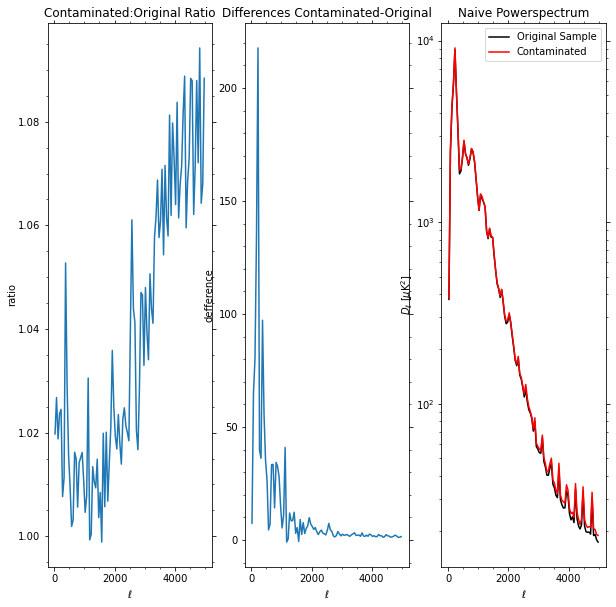

In [130]:
%%time
ell,DlTT,lTT2,lTT3,lTT4,lTT5 = np.loadtxt(f"CMBAnalysis_SummerSchool/CAMB_fiducial_cosmo_scalCls.dat",
                                            usecols=(0,1,2,3,4,5), unpack=True)

################## Arrays of everything
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT,random=False) 
#################### Original CMBT
fig = plt.figure(figsize=(10,10)) #for (2x5)->(30,10),(2x6)->(27,9)
# ax = fig.add_subplot(1,1,1)
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT,random=False)


divide =  3
div_tot = N/divide
Gain = centered_percent_diff_array(1,.1,div_tot,N)
Gain_array_map = effect_Map_array(Gain,divide,N)
Contaminated_CMB = Gain_array_map*CMB_T

CM = [CMB_T,Contaminated_CMB]

powers = []
for i,x in enumerate(CM):
    binned_ell,power = calculate_2d_spectrum(CM[i],CM[i],delta_ell,ell_max,pix_size,N)
    powers.append(power)

ind_per_deg = X_width/N
one_deg = int(1/ind_per_deg)
diam = one_deg
circ = makeCircle(int(N/2),int(N/2),diam,N,N)

Convololved_Gain = convolution(Gain_array_map,circ)
###VOLTAGE###
K2Vconv=1
perc_gain=.3
temp2change=300
# plot_volt_gain(CMB_T,ax,K2Vconv=K2Vconv,perc_gain=perc_gain,temp2change=temp2change)
white_noise = np.random.normal(0,1,(N,N)) * 10/pix_size
Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width,ax,bars=True)
plot_ratio(binned_ell,powers,ax1)
plot_diff(powers,ax2)
plot_powers(binned_ell,powers,ax3)

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'

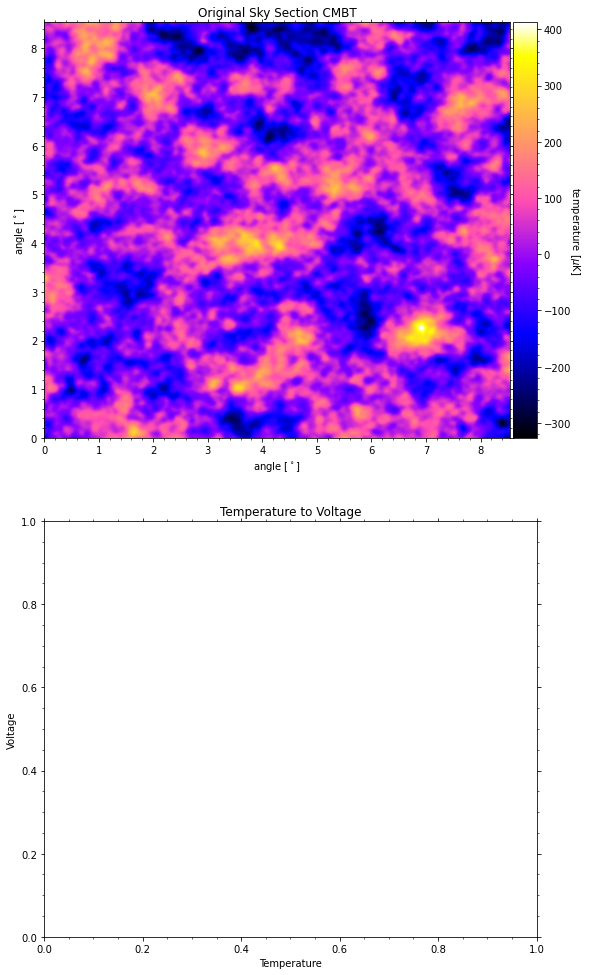

In [91]:
%%time
# experiment = '.3 Voltage Drop Off'
# path = f'./{experiment}'
# isExist = os.path.exists(path)
# if not isExist:
#     os.makedirs(path)
#     os.makedirs(f'{path}/Data')
#     os.makedirs(f'{path}/Images')
#     os.makedirs(f'{path}/Analysis')


ell,DlTT,lTT2,lTT3,lTT4,lTT5 = np.loadtxt(f"CMBAnalysis_SummerSchool/CAMB_fiducial_cosmo_scalCls.dat",
                                            usecols=(0,1,2,3,4,5), unpack=True)
divide =  3                                    ### how many divisinons
div_tot = N/divide                             ### number of arrayss in each strip
Gain = centered_percent_diff_array(1,.1,div_tot,N)            ### Gain
Gain_array_map = effect_Map_array(Gain,divide,N) ### NxN array of Gain

###CIRCLE####
ind_per_deg = X_width/N
one_deg = int(1/ind_per_deg)
diam = one_deg
circ = makeCircle(int(N/2),int(N/2),diam,N,N)
        #centerX, centerY, radius, array, arrayWidth, arrayHeight

###VOLTAGE###
K2Vconv=1
perc_gain=.3
temp2change=300


# for repitition in range(100):
#     repitition += 98
plt.close()
################## Arrays of everything
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT,random=False)    ### CMBT
CMB_T = CMB_T-np.mean(CMB_T)
Contaminated_CMB = volt_gain(CMB_T,K2Vconv=K2Vconv,perc_gain=perc_gain,temp2change=temp2change)
Contaminant = Contaminated_CMB/CMB_T
Contaminated_CMB = Contaminated_CMB-np.mean(Contaminated_CMB)
#     Gain_array_map = Contaminated_CMB/CMB_T
# Contaminated_CMB = Gain_array_map*CMB_T                    ### Contaminated CMBT
# Convololved_Gain = convolution(Gain_array_map,circ) 
# Convololved_CMB = Convololved_Gain*CMB_T
CM = [CMB_T,Contaminated_CMB]                              ### Original CMBT and Contaminated CMBT

powers = []
for i,x in enumerate(CM):
    binned_ell = calculate_2d_spectrum(CM[i],CM[i],delta_ell,ell_max,pix_size,N)[0]
    power = calculate_2d_spectrum(CM[i],CM[i],delta_ell,ell_max,pix_size,N)[1]
    powers.append(power)

#################### Original CMBT
fig = plt.figure(figsize=(30,26)) #for (2x5)->(30,10),(2x6)->(27,9)
fig.patch.set_facecolor('white')
ax = fig.add_subplot(3,3,1)
ax.set_title('Original Sky Section CMBT')
Plot_CMB_Map(CM[0],c_min,c_max,X_width,Y_width,ax)

# #################### Contaminant Color Plot
# ax = fig.add_subplot(3,3,4)
# plot_cont(Gain_array_map,X_width,Y_width,ax)

#################### Volatage Gain Plot
ax = fig.add_subplot(3,3,4)
plot_volt_gain(CM[0],ax,K2Vconv=K2Vconv,perc_gain=perc_gain,temp2change=temp2change)

#     # ##################### Circle Color Map
#     ax = fig.add_subplot(3,3,7)
#     plot_circ(circ,diam,ind_per_deg,X_width,Y_width,ax)

# ##################### Convololved Gain Map
# ax = fig.add_subplot(3,3,2)
# plot_conv(Convololved_Gain,X_width,Y_width,ax)

# ax = fig.add_subplot(3,3,2)
# plot_cont(Contaminant,X_width,Y_width,ax)

#################### Contaminated CMB
ax = fig.add_subplot(3,3,3)
ax.set_title('Contaminated CMBT')
Plot_CMB_Map(CM[1],c_min,c_max,X_width,Y_width,ax)

#################### Power Spectrum Data Plot
ax = fig.add_subplot(3,3,5)
plot_powers(binned_ell,powers,ax)

#################### Ratio Plot
ax = fig.add_subplot(3,3,6)
plot_ratio(binned_ell,powers,ax)

#################### Difference Plot
ax = fig.add_subplot(3,3,8)
plot_diff(powers,ax)

#     fig.savefig(f'{experiment}/Images/Plots_{int(repitition)}.png')
#     plt.close()
#     ################## Data table
#     rows = []
#     for i,x in enumerate(powers[0]):
#         rows.append([binned_ell[i],powers[1][i],powers[0][i],powers[1][i]/powers[0][i],powers[1][i]-powers[0][i]])
#     pd.DataFrame(rows,columns=['ell','DlTT_c','DlTT','ratio','difference']).to_csv(f'{experiment}/Data/Results_{int(repitition)}.csv',index=False)
#     print(repitition,end=', ')